C:\Users\adity\AppData\Local\Temp\ipykernel_30616\1718607850.py:99: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best = merged.groupby("strike").apply(
C:\Users\adity\AppData\Local\Temp\ipykernel_30616\1718607850.py:99: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best = merged.groupby("strike").apply(
C:\Users\adity\AppData\Local\Temp\ipykernel_30616\1718607850.py:99: DeprecationWarning: DataFrameGroupBy

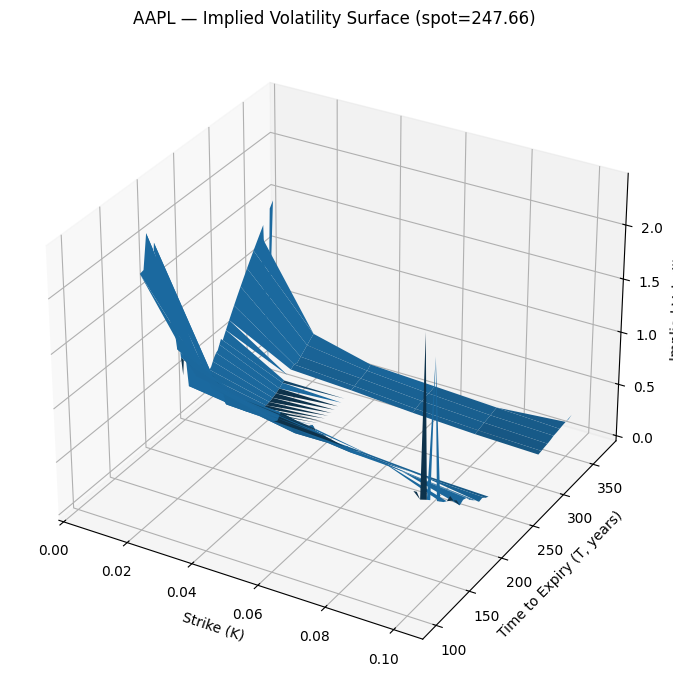

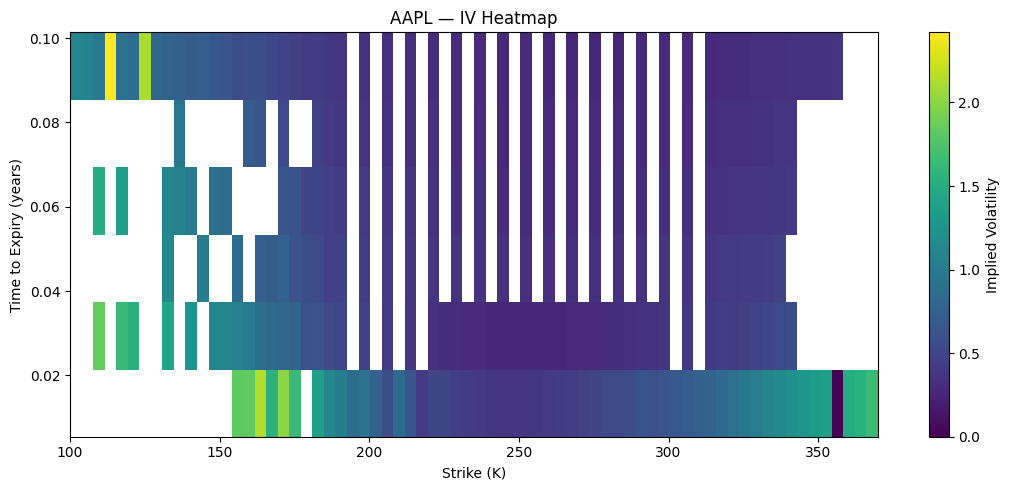

Saved points to AAPL_iv_surface_points.csv
   strike     mid         T        iv      expiry
0   170.0  77.700  0.005479  1.819325  2025-10-17
1   175.0  72.725  0.005479  1.828671  2025-10-17
2   180.0  67.950  0.005479  2.137855  2025-10-17
3   185.0  62.725  0.005479  1.557065  2025-10-17
4   190.0  58.150  0.005479  2.000905  2025-10-17


In [2]:
# Step 10 — Implied Volatility Surface (Strike × Maturity × IV)
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timezone
from scipy.stats import norm

# ---------------- Black–Scholes & IV (binary search) ---------------- #
def bs_call_price(S, K, T, r, sigma):
    if T <= 0:
        return max(S - K, 0.0)
    if sigma <= 0:
        return max(0.0, S - K*np.exp(-r*T))
    d1 = (np.log(S/K) + (r + 0.5*sigma*sigma)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def implied_vol_binary(C_mkt, S, K, T, r=0.02, tol=1e-6, max_iter=100, low=1e-6, high=5.0):
    # Handle edge cases
    intrinsic = max(0.0, S - K*np.exp(-r*T))
    if C_mkt < max(0.0, S - K*np.exp(-r*T)) - 1e-9:
        return np.nan  # below intrinsic, likely bad quote
    if abs(C_mkt - intrinsic) < 1e-12:
        return 0.0
    lo, hi = low, high
    for _ in range(max_iter):
        mid = 0.5*(lo + hi)
        price = bs_call_price(S, K, T, r, mid)
        if abs(price - C_mkt) < tol:
            return mid
        if price > C_mkt:
            hi = mid
        else:
            lo = mid
    return mid  # best effort

# ---------------- Pull options, compute IV surface ---------------- #
def iv_surface_from_yahoo(ticker="AAPL", max_expiries=6, use_puts_if_missing=True, r=0.02):
    tk = yf.Ticker(ticker)
    spot_series = tk.history(period="1d")["Close"]
    if spot_series.empty:
        raise SystemExit("No spot data returned—check ticker/internet.")
    S = float(spot_series.iloc[-1])

    expiry_list = tk.options
    if not expiry_list:
        raise SystemExit("No options available for this ticker.")
    expiry_list = expiry_list[:max_expiries]

    rows = []
    now = datetime.now(timezone.utc)

    for exp in expiry_list:
        chain = tk.option_chain(exp)
        calls = chain.calls.copy()
        puts  = chain.puts.copy()

        # Choose calls primarily
        df = calls.copy()
        if df.empty and use_puts_if_missing:
            # fall back to puts; convert put mid to call via parity only if needed (simplify: treat as put IV later)
            df = puts.copy()

        if df.empty:
            continue

        # mid price
        for side_df, side in [(calls, "C"), (puts, "P")]:
            if not side_df.empty:
                side_df["mid"] = (side_df["bid"].fillna(0) + side_df["ask"].fillna(0)) / 2.0
                side_df["side"] = side

        # Merge calls/puts if we decide to use both for coverage; priority to calls’ mid when both exist
        merged = None
        if not calls.empty:
            merged = calls[["strike", "lastPrice", "mid", "side"]].rename(columns={"lastPrice": "last"})
        if use_puts_if_missing and not puts.empty:
            psel = puts[["strike", "lastPrice", "mid", "side"]].rename(columns={"lastPrice": "last"})
            if merged is None:
                merged = psel
            else:
                merged = pd.concat([merged, psel], ignore_index=True)

        if merged is None or merged.empty:
            continue

        # Time to expiry
        exp_dt = pd.to_datetime(exp).tz_localize("UTC")
        T = max((exp_dt - now).days / 365.0, 1e-6)

        # For each strike, prefer call mid if available else put mid
        # (Simple approach; parity refinements omitted for clarity)
        # Group by strike and pick priority: C then P
        merged = merged.dropna(subset=["mid"])
        if merged.empty:
            continue
        merged.sort_values(["strike", "side"], ascending=[True, True], inplace=True)
        best = merged.groupby("strike").apply(
            lambda g: g[g["side"]=="C"]["mid"].iloc[0] if (g["side"]=="C").any() else g["mid"].iloc[0]
        ).reset_index().rename(columns={0: "mid"})
        best["T"] = T

        # Compute IVs
        best["iv"] = best.apply(lambda row: implied_vol_binary(row["mid"], S, float(row["strike"]), row["T"], r=r), axis=1)
        best["expiry"] = exp
        rows.append(best)

    if not rows:
        raise SystemExit("No usable option quotes to compute IVs.")
    iv_table = pd.concat(rows, ignore_index=True)
    iv_table = iv_table.dropna(subset=["iv"])
    iv_table = iv_table.sort_values(["T", "strike"]).reset_index(drop=True)
    return S, iv_table

# ---------------- Plotting helpers ---------------- #
def plot_iv_surface(iv_table, ticker, S):
    # Build pivot grid: rows = T, cols = strike, values = iv
    piv = iv_table.pivot_table(index="T", columns="strike", values="iv")
    Ts = piv.index.values
    Ks = piv.columns.values
    Z = piv.values  # (len(Ts), len(Ks))

    # --- 3D Surface ---
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
    Tmesh, Kmesh = np.meshgrid(Ks, Ts)

    fig = plt.figure(figsize=(11, 7))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(Kmesh, Tmesh, Z, linewidth=0, antialiased=True)
    ax.set_xlabel("Strike (K)")
    ax.set_ylabel("Time to Expiry (T, years)")
    ax.set_zlabel("Implied Volatility")
    ax.set_title(f"{ticker} — Implied Volatility Surface (spot={S:.2f})")
    plt.tight_layout()
    plt.show()

    # --- 2D Heatmap ---
    plt.figure(figsize=(11, 5))
    plt.imshow(Z, aspect="auto", origin="lower",
               extent=[Ks.min(), Ks.max(), Ts.min(), Ts.max()])
    plt.colorbar(label="Implied Volatility")
    plt.xlabel("Strike (K)")
    plt.ylabel("Time to Expiry (years)")
    plt.title(f"{ticker} — IV Heatmap")
    plt.tight_layout()
    plt.show()

    return piv

# ---------------- Run demo ---------------- #
if __name__ == "__main__":
    ticker = "AAPL"
    r = 0.02         # flat risk-free. Adjust if you have a curve.
    max_expiries = 6 # pull first 6 expiries for speed

    S, iv_table = iv_surface_from_yahoo(ticker=ticker, max_expiries=max_expiries, r=r)
    piv = plot_iv_surface(iv_table, ticker, S)

    # Save CSV for later analysis
    iv_table.to_csv(f"{ticker}_iv_surface_points.csv", index=False)
    print(f"Saved points to {ticker}_iv_surface_points.csv")
    print(iv_table.head())
